# 🏷️ Sneakers Classification using Neural Networks

Welcome!  
In this notebook, we explore the task of classifying sneakers based on images using deep learning. Our dataset is sourced from [this Kaggle dataset](https://www.kaggle.com/datasets/nikolasgegenava/sneakers-classification), which contains labeled images of different sneaker types.

The goal of this project is to build a convolutional neural network (CNN) that can accurately predict the class of a sneaker from an image. This type of model has practical applications in fashion recommendation systems, e-commerce, and inventory management.

---

## 📦 Dataset Overview

The dataset includes:

- High-quality images of sneakers across multiple classes.
- Labels corresponding to sneaker categories (e.g., running shoes, basketball shoes, etc.).

We will go through the following steps:

1. **Data Loading & Visualization**  
   Understand the structure and distribution of the data.

2. **Data Preprocessing**  
   Resize, normalize, and augment images for training.

3. **Model Building**  
   Define a convolutional neural network (CNN) using PyTorch/TensorFlow.

4. **Training & Evaluation**  
   Train the model, track metrics, and evaluate performance on test data.

5. **Results & Discussion**  
   Analyze the model's accuracy, strengths, and areas for improvement.

---

Let’s get started! 🔍


In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader , random_split
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

### Loading And Processing Dataset

In [2]:
data_info = pd.read_csv("./dataset/dataset_stats.csv")
data_info.head()

,class,image_count,avg_width,avg_height,min_width,min_height,max_width,max_height,formats,corrupt_files
0,adidas_forum_high,150,143,124,78,81,162,140,jpeg,0
1,adidas_ultraboost,150,142,128,93,49,162,140,jpeg,0
2,new_balance_550,150,134,129,79,40,162,140,jpeg,0
3,new_balance_574,150,131,133,78,68,162,140,jpeg,0
4,converse_one_star,150,138,130,82,67,162,140,jpeg,0


In [3]:
# finding maximum size of an image
max_width = 0
max_height = 0
total_images = 0

for ind,row in data_info.iterrows():
    max_width = max(max_width,row["max_width"])
    max_height = max(max_height,row["max_height"])
    total_images += row["image_count"]

print(f"Max width of any image: {max_width}\nMax Height Of Any Image: {max_height}")
print("Total Number Of Images:",total_images)

Max width of any image: 300
Max Height Of Any Image: 140
Total Number Of Images: 5953


In [4]:
#Transforming each image
transform = transforms.Compose([
    transforms.Resize((300, 140)),
    transforms.RandomHorizontalFlip(),        # basic augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

#loading the images into dataset
dataset = datasets.ImageFolder(root='./dataset/sneakers-dataset/sneakers-dataset', transform=transform)

label_map = {}
label = 0
for _,row in data_info.iterrows():
    label_map[label] = row["class"]
    label+=1

In [5]:
# splitting dataset

# Calculate sizes
total_size = len(dataset)
test_size = int(0.1 * total_size)  # 10%
train_size = total_size - test_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=2,shuffle=True)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 5364
Test size: 596


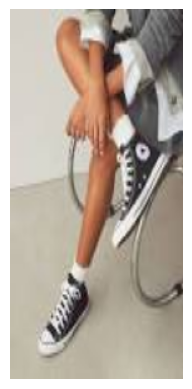

Label: converse_chuck_taylor_all-star_high
torch.Size([32, 3, 300, 140]) tensor(11)


In [6]:
# Displaying an image

# Function to unnormalize and convert tensor to numpy image for display
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # C,H,W -> H,W,C
    img = img * 0.5 + 0.5  # Undo normalization (assuming mean=0.5, std=0.5)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Show first image in the batch
imshow(images[0])
print(f"Label: {train_dataset.dataset.classes[labels[0]]}")

# tensor size and label
print(images.shape,labels[0])

### Neural Net

In [9]:
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SneakerCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(SneakerCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (3, 300, 140) → (32, 300, 140)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (32, 150, 70)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # → (64, 150, 70)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (64, 75, 35)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# → (128, 75, 35)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (128, 37, 17)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 37 * 17, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### Hyperparameters

In [10]:
# Model
model = SneakerCNN(num_classes=50).to(device)

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Epochs & Batch Size
num_epochs = 30
batch_size = 32

### Training

In [12]:
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    model.train()  # set model to training mode
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)  # shape: [32, 3, 300, 140]
        labels = labels.to(device)
        
        # Forward pass and loss calculation
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

/Users/sanchaysingh/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/30], Step [100/168], Loss: 3.8008
Epoch [2/30], Step [100/168], Loss: 3.6955
Epoch [3/30], Step [100/168], Loss: 3.7681
Epoch [4/30], Step [100/168], Loss: 3.6574
Epoch [5/30], Step [100/168], Loss: 3.4082
Epoch [6/30], Step [100/168], Loss: 3.3347
Epoch [7/30], Step [100/168], Loss: 3.2054
Epoch [8/30], Step [100/168], Loss: 2.8029
Epoch [9/30], Step [100/168], Loss: 2.8121
Epoch [10/30], Step [100/168], Loss: 2.8357
Epoch [11/30], Step [100/168], Loss: 1.8970
Epoch [12/30], Step [100/168], Loss: 1.3838
Epoch [13/30], Step [100/168], Loss: 1.5293
Epoch [14/30], Step [100/168], Loss: 1.8117
Epoch [15/30], Step [100/168], Loss: 0.8082
Epoch [16/30], Step [100/168], Loss: 1.0391
Epoch [17/30], Step [100/168], Loss: 1.1079
Epoch [18/30], Step [100/168], Loss: 1.4825
Epoch [19/30], Step [100/168], Loss: 0.8570
Epoch [20/30], Step [100/168], Loss: 0.7504
Epoch [21/30], Step [100/168], Loss: 0.7941
Epoch [22/30], Step [100/168], Loss: 0.3626
Epoch [23/30], Step [100/168], Loss: 0.31

### Testing On Training Set

In [13]:
with torch.no_grad():
    n_correct = 0
    n_samples = len(train_loader.dataset)

    for images, labels in train_loader:
        labels = labels.to(device)

        outputs = model(images)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} train images: {100*acc} %')

Accuracy of the network on the 5364 train images: 85.57046979865773 %


### Testing On Test Set

In [14]:
with torch.no_grad():
    n_correct = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        labels = labels.to(device)

        outputs = model(images)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} train images: {100*acc} %')

Accuracy of the network on the 596 train images: 19.966442953020135 %


In [15]:
torch.save(model.state_dict(), "model_weights.pth")